# Reinforcement Learning with Function Approximation

In [25]:
!pip install torch==1.2.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb x11-utils
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull origin master > /dev/null 2>&1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
from pathlib import Path
import math
import base64
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |


**Tutorials on PyTorch:** https://pytorch.org/tutorials/


## OpenAI gym
We will consider environments provided by OpenAI gym
This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

In [0]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [28]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

**Q1: Implement the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [0]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        p = self.forward(state)
        action = torch.multinomial(p, 1)
        log_proba = torch.log(p[action])
        return action, log_proba

Create the model based on the properties of the MDP you want to solve

In [30]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
)


We provide a base agent that you will need to extend in the next cell with your implementation of `optimize_model`.

In [0]:
class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    # Method to implement
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """

        raise NotImplementedError
    
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        with torch.no_grad():
            observation = self.monitor_env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode = 0
            done = False
                
            while not done:
                action, _ = self.model.select_action(observation)
                observation, reward, done, info = self.monitor_env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward
            
            self.monitor_env.close()
            if render:
                show_video("./gym-results")
                print(f'Reward: {reward_episode}')
            print(f'Reward: {reward_episode}')

Finally you can implement your agent

In [0]:
class REINFORCE(BaseAgent):
    
    def _compute_returns(self, rewards):
        T = len(rewards)
        res = np.zeros(T)
        gammas = self.gamma**np.arange(T)
        for i in range(T):
          res[i] = np.sum(rewards[i:]*gammas[:T-i])
        return res
    
        
    def optimize_model(self, n_trajectories):
        reward_trajectories = []
        J = []

        for i in range(n_trajectories):
            done = False
            s0 = self.env.reset()
            log_probs = []
            rewards = []

            while not done:
                action, log_prob = self.model.select_action(torch.FloatTensor(s0))
                s1, reward, done, info = self.env.step(int(action))

                log_probs.append(log_prob)
                rewards.append(reward)
                s0 = s1
            
            reward_trajectories.append(np.sum(rewards))
            disc_rewards = self._compute_returns(rewards)
            for i in range(len(disc_rewards)):
                J.append(-disc_rewards[i] * log_probs[i])

        self.optimizer.zero_grad()
        loss = torch.stack(J).mean()
        loss.backward()

        # Do the gradient descent step
        self.optimizer.step()
        return np.array(reward_trajectories)
    

In [33]:
env_id = 'CartPole-v1'
learning_rate = 0.01
gamma = 1 
seed = 1235

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1', 'gamma': 1, 'learning_rate': 0.01, 'seed': 1235}


In [0]:
agent = REINFORCE(config)

Episode 1/50: rewards 16.9 +/- 6.2
Episode 2/50: rewards 22.48 +/- 9.21
Episode 3/50: rewards 22.7 +/- 11.96
Episode 4/50: rewards 23.44 +/- 11.93
Episode 5/50: rewards 21.92 +/- 10.02
Episode 6/50: rewards 22.62 +/- 13.48
Episode 7/50: rewards 23.42 +/- 9.84
Episode 8/50: rewards 25.48 +/- 12.17
Episode 9/50: rewards 23.06 +/- 9.69
Episode 10/50: rewards 24.7 +/- 13.26
Episode 11/50: rewards 26.22 +/- 16.31
Episode 12/50: rewards 28.02 +/- 18.57
Episode 13/50: rewards 31.08 +/- 19.32
Episode 14/50: rewards 29.74 +/- 15.11
Episode 15/50: rewards 30.76 +/- 15.9
Episode 16/50: rewards 36.06 +/- 22.43
Episode 17/50: rewards 27.9 +/- 12.09
Episode 18/50: rewards 39.26 +/- 21.95
Episode 19/50: rewards 36.16 +/- 23.68
Episode 20/50: rewards 38.26 +/- 23.66
Episode 21/50: rewards 41.82 +/- 28.26
Episode 22/50: rewards 45.16 +/- 21.71
Episode 23/50: rewards 38.66 +/- 15.77
Episode 24/50: rewards 39.16 +/- 16.96
Episode 25/50: rewards 50.9 +/- 25.08
Episode 26/50: rewards 52.86 +/- 23.77
Episod

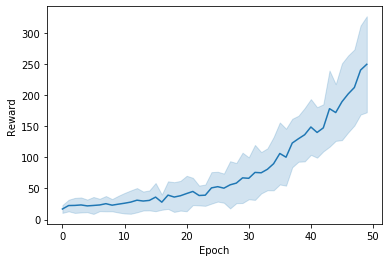

In [35]:
agent.train(n_trajectories=50, n_update=50)

Evaluate the agent over multiple episodes

In [36]:
agent.evaluate(render=True)

Reward: 153.0
Reward: 153.0


## Policy Evaluation as Supervised Learning

**Q2: Implement batched gradient algorithm**

Define network for Q-function (ValueNetwork) and policy (ActorNetwork)


In [0]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()

In [0]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

Implement your (batched) gradient algorithm



In [0]:
class EvalAgent:

    def __init__(self, config, policy):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.policy = policy

        # Our network
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)

        # optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), 
                                                   lr=config['value_network']['learning_rate'])
    
    def _returns_advantages(self, rewards, dones, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        returns : array
            The cumulative discounted rewards
        """

        T = len(rewards)
        res = np.zeros(T)
        gammas = self.gamma**np.arange(T+1)
        listIndex = np.where(dones == True)[0]
        listIndex = np.append([0], listIndex)
        for k in range(len(listIndex)-1):
          for i in range(listIndex[k],listIndex[k + 1] + 1):
            res[i] = np.sum(rewards[i:(listIndex[k + 1] + 1)]*gammas[:(listIndex[k + 1] + 1 - i)])
        if listIndex[-1] != T:
          for i in range(listIndex[-1], T):
            res[i] = np.sum(np.append(rewards[i:T], [next_value])*gammas[:(T + 1 - i)])
        return res
    
    
    def optimize_model(self, observations, actions, returns):
        """Perform a gradient update using provided transitions

        Parameters
        ----------
        observations : array
            The observations
        actions : array
            The actions
        returns : array
            The returns from each state

        Returns
        -------
        loss_value: int
            The loss value
        """
        #actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        self.value_network_optimizer.zero_grad()
        inp = self.value_network.forward(observations)#requires_grad=True
        loss = nn.MSELoss()
        output = loss(inp, returns)
        output.backward()
        self.value_network_optimizer.step()
        return output
    
    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        action = self.policy.select_action(torch.tensor(observation, dtype=torch.float))
        mse_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation
                actions[i] = action
                values[i] = self.value_network.predict(torch.tensor(observation, dtype=torch.float))
                observation, reward, done, info = self.env.step(int(action))
                rewards[i] = reward
                dones[i] = done
                action = self.policy.select_action(torch.tensor(observation, dtype=torch.float))
                # step
                if dones[i]:
                    observation = self.env.reset()
                    action = self.policy.select_action(torch.tensor(observation, dtype=torch.float))

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network.predict(torch.tensor(observation, dtype=torch.float))

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns = self._returns_advantages(rewards, dones, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns)

            # Test it every 50 epochs
            if epoch % 25 == 0 or epoch == epochs - 1:
                L = []
                for _ in range(10):
                    obs_states, y_mc = self.evaluate()
                    y_hat = self.value_network.predict(torch.tensor(obs_states, dtype=torch.float))
                    err = y_mc - y_hat
                    mse = np.mean(err**2)
                    L.append(mse.item())
                mse_test.append(L)
                print(f'Epoch {epoch}/{epochs}: MSE: {np.mean(mse)}')

                observation = self.env.reset()

        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], mse_test[i]) for i in range(len(mse_test))))), columns=['Epoch', 'MSE'])
        sns.lineplot(x="Epoch", y="MSE", data=r, ci='sd');

        print(f'The trainnig was done over a total of {episode_count} episodes')

    def evaluate(self, render=False):
        """Returns the observations and the estimated V-function (using first visit Monte-Carlo)

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        states : array
            Observations
        returns : array
            The estimate value function of each state
        """
        env = self.monitor_env if render else self.env
        observation = env.reset()
        states = [observation.copy()]
        rewards= []
        observation = torch.tensor(observation, dtype=torch.float)
        done = False
        steps = 0

        while not done:
            action = self.policy.select_action(observation)
            observation, reward, done, info = env.step(int(action))
            for i in range(steps):
                rewards[i] = rewards[i] + math.pow(self.gamma, steps-i)*reward
            rewards.append(reward)
            if not done:
                states.append(observation.copy())
            observation = torch.tensor(observation, dtype=torch.float)
            steps += 1

        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        states = np.array(states).reshape(-1, self.env.observation_space.shape[0])
        returns = np.array(rewards).reshape(-1,1)
        return states, returns

Define configuration

In [40]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
gamma = 0.99
seed = 1

config_td = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate, 'reference': './CartPole_value.pt'}
}

print("Current config_td is:")
pprint(config_td)


Current config_td is:
{'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001, 'reference': './CartPole_value.pt'}}


Create policy

In [41]:
env = gym.make(config_td['env_id'])
policy = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
policy.load_state_dict(torch.load('./mvarl_hands_on/data/CartPole_actor.pt'))
state = torch.tensor(np.array(env.reset(), dtype=np.float32))
print("pi(state) = ", policy.select_action(state))
del env

pi(state) =  [1]


Run agent

Epoch 0/1000: MSE: 7039.192746918926
Epoch 25/1000: MSE: 6969.131259438612
Epoch 50/1000: MSE: 6835.056535845665
Epoch 75/1000: MSE: 6669.228551857719
Epoch 100/1000: MSE: 6430.285455037145
Epoch 125/1000: MSE: 3405.052894899822
Epoch 150/1000: MSE: 5826.745827081611
Epoch 175/1000: MSE: 5527.74132023809
Epoch 200/1000: MSE: 3015.929393368864
Epoch 225/1000: MSE: 4604.076120803686
Epoch 250/1000: MSE: 4308.727925903526
Epoch 275/1000: MSE: 3914.1500439337965
Epoch 300/1000: MSE: 3415.1741771195598
Epoch 325/1000: MSE: 3043.6111698675554
Epoch 350/1000: MSE: 2648.8302715694526
Epoch 375/1000: MSE: 2227.553862626229
Epoch 400/1000: MSE: 1780.064239700782
Epoch 425/1000: MSE: 1296.2795136039856
Epoch 450/1000: MSE: 1247.3371044606195
Epoch 475/1000: MSE: 1156.5768327604494
Epoch 500/1000: MSE: 1004.300963362331
Epoch 525/1000: MSE: 925.1255126173772
Epoch 550/1000: MSE: 773.9463707852461
Epoch 575/1000: MSE: 746.3542953856778
Epoch 600/1000: MSE: 670.2503258314747
Epoch 625/1000: MSE: 601

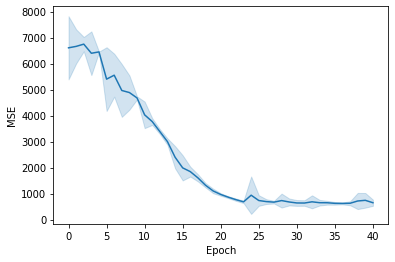

In [42]:
agent = EvalAgent(config=config_td, policy=policy)
agent.training_batch(epochs=1000, batch_size=256)

## Advantage Actor Critic (A2C)
**Q3: Implement the A2C method**

As usual we provide a structure you can use as starting point.



**Note:** try to reuse previous parts of previous code.



In [0]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        ### Returns
        T = len(rewards)
        res = np.zeros(T)
        gammas = self.gamma**np.arange(T+1)
        listIndex = np.where(dones == True)[0]
        listIndex = np.append([0], listIndex)
        for k in range(len(listIndex)-1):
          for i in range(listIndex[k],listIndex[k + 1] + 1):
            res[i] = np.sum(rewards[i:(listIndex[k + 1] + 1)]*gammas[:(listIndex[k + 1] + 1 - i)])
        if listIndex[-1] != T:
          for i in range(listIndex[-1], T):
            res[i] = np.sum(np.append(rewards[i:T], [next_value])*gammas[:(T + 1 - i)])
        
        ### Advantages
        advantages = np.zeros(T)
        for k in range(T-1):
          if dones[k]:
            advantages[k] = rewards[k] - values[k]
          else:
            advantages[k] = rewards[k] + self.gamma * values[k+1] - values[k]
        if dones[T-1]:
          advantages[T-1] = rewards[T-1] - values[T-1]
        else:
          advantages[T-1] = rewards[T-1] + self.gamma * next_value - values[T-1]
        return res, advantages

    def training_batch(self, epochs, batch_size):
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        action = self.actor_network.select_action(torch.tensor(observation, dtype=torch.float))
        rewards_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation
                actions[i] = action
                values[i] = self.value_network.predict(torch.tensor(observation, dtype=torch.float))
                observation, reward, done, info = self.env.step(int(action))
                rewards[i] = reward
                dones[i] = done
                action = self.actor_network.select_action(torch.tensor(observation, dtype=torch.float))
                # step
                if dones[i]:
                    observation = self.env.reset()
                    action = self.actor_network.select_action(torch.tensor(observation, dtype=torch.float))
            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network.predict(torch.tensor(observation, dtype=torch.float))
            # Update episode_count
            episode_count += sum(dones)

            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns, advantages, episode_count)

            # Test it every 50 epochs
            if epoch % 50 == 0 or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

                # Early stopping
                if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                    print('Early stopping !')
                    break
                observation = self.env.reset()
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');        
        print(f'The trainnig was done over a total of {episode_count} episodes')




    def optimize_model(self, observations, actions, returns, advantages, nbtraj):
        #actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)

        # MSE for the values
        self.value_network_optimizer.zero_grad()
        inp = self.value_network.forward(observations)
        loss = nn.MSELoss()
        output = loss(inp, returns)
        output.backward()
        self.value_network_optimizer.step()

        # Actor & Entropy loss
        J = []
        for k in range(len(advantages)):
          p = self.actor_network.forward(observations[k])
          log_proba = torch.log(p[actions[k]])
          J.append(-1*log_proba * advantages[k])
        self.actor_network_optimizer.zero_grad()
        loss = (1/nbtraj) * torch.stack(J).sum()
        loss.backward()
        # Do the gradient descent step
        self.actor_network_optimizer.step()


    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

Create configuration for A2C

In [44]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
actor_learning_rate = 0.001
gamma = 0.99
entropy = 1
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 1,
 'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


Run the learning agent

Epoch 0/4000: Mean rewards: 19.56, Std: 8.62
Epoch 50/4000: Mean rewards: 18.02, Std: 7.6
Epoch 100/4000: Mean rewards: 14.94, Std: 5.11
Epoch 150/4000: Mean rewards: 11.54, Std: 3.23
Epoch 200/4000: Mean rewards: 12.06, Std: 3.01
Epoch 250/4000: Mean rewards: 11.92, Std: 3.03
Epoch 300/4000: Mean rewards: 13.08, Std: 3.46
Epoch 350/4000: Mean rewards: 12.4, Std: 3.36
Epoch 400/4000: Mean rewards: 12.72, Std: 4.55
Epoch 450/4000: Mean rewards: 12.4, Std: 3.34
Epoch 500/4000: Mean rewards: 12.16, Std: 3.45
Epoch 550/4000: Mean rewards: 13.04, Std: 4.28
Epoch 600/4000: Mean rewards: 12.76, Std: 3.64
Epoch 650/4000: Mean rewards: 14.56, Std: 5.36
Epoch 700/4000: Mean rewards: 14.94, Std: 6.02
Epoch 750/4000: Mean rewards: 17.76, Std: 7.93
Epoch 800/4000: Mean rewards: 20.6, Std: 9.64
Epoch 850/4000: Mean rewards: 21.54, Std: 8.81
Epoch 900/4000: Mean rewards: 30.48, Std: 16.49
Epoch 950/4000: Mean rewards: 42.32, Std: 24.99
Epoch 1000/4000: Mean rewards: 50.0, Std: 19.74
Epoch 1050/4000: 

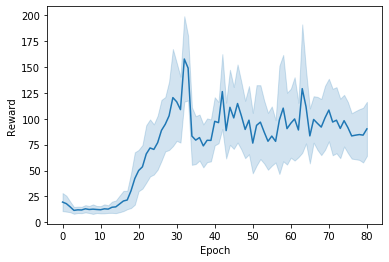

In [45]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(4000, 256)
#rewards = agent.training_batch(1, 10)

Evaluate the agent over multiple episodes

In [46]:
agent.evaluate()

74.0